## Note:

Initially this was a university project. It was provided in docx format, and the main stages of clustering (using various algorithms, visual interpretation of the results) were done in the interactive Orange program. In order to get acquainted with the main methods and results, it was decided to post the implementation of the study, adapted to the Python language, on GitHub



# 1 Introduction

### 1.1 Problem statement

It can often be difficult to find a suitable TV series to watch. Therefore, it makes sense to create an algorithm that will help people with this

### 1.2 Implementation plan

All the series have certain characteristics. Therefore, it makes sense to watch series whose characteristics are similar to those of our favorite series. To do this, you can select groups of series by clustering. Sorting serials by clustering will solve several problems: 

1) help in finding the series 

2) no disappointment and waste of time

3) getting rid of obviously unsuitable series

### 1.3 Data sources and dataset creation

Let's take the top-50 series of Kinopoisk and create a dataset that displays the main characteristics (indicated on the website) of the series

Remember that initially this was a university project, hence, the data is in Russian


### 1.4 First-order data analysis
Let's look at the distributions of key characteristics (binary, such as the presence / absence of a particular genre; discrete, such as age restrictions; continuous, such as rating) using histograms, as well as the dependencies of certain parameters using a correlation matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
movies = pd.read_excel('file')

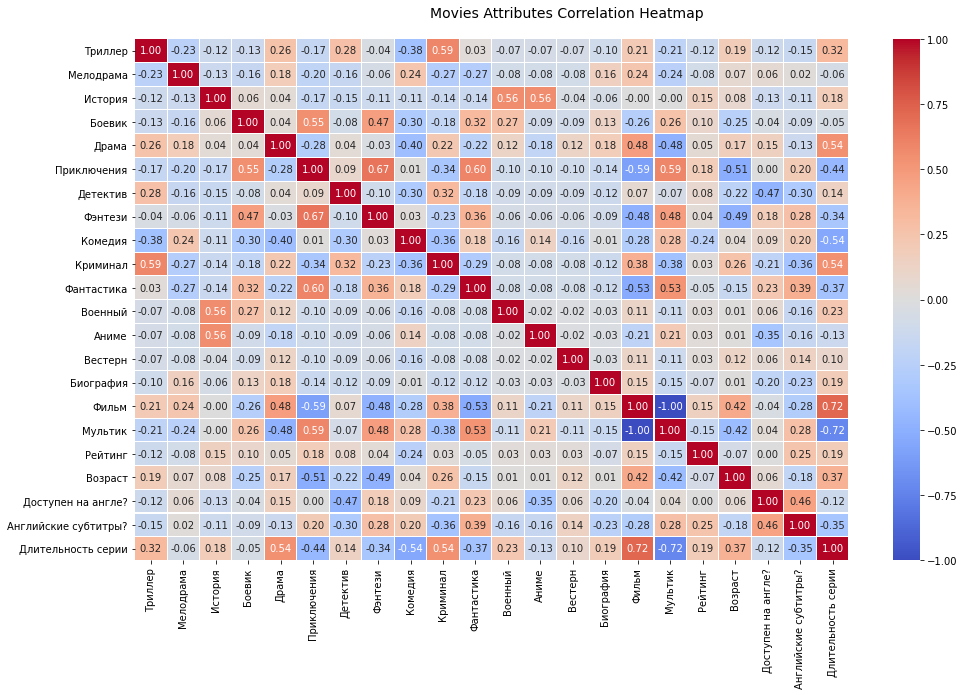

In [3]:
f, ax = plt.subplots(figsize = (10, 6))
corr = movies.corr()
hm = sns.heatmap(round(corr,2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = .93)
t= f.suptitle('Movies Attributes Correlation Heatmap', fontsize = 14)
plt.gcf().set_size_inches(16, 9)

###### 1.4.1 Interpretation of the results obtained by the analysis of correlation matrix

We are not interested in weak correlation, as it does not provide us with useful information. Let's mention interesting observations that do not follow from common sense (I will assume that absolute values from 0.5 to 0.7 mean an average correlation; from 0.7 to 0.9 – high, from 0.9 to 1 – very high):

1) The film is strongly positively correlated with the length of the episodes, the case with the cartoon is the opposite, which automatically means that episodes in films last almost always or always longer than in cartoons

2) There is a correlation between certain genres (for example, a thriller is often also a crime, and an adventure frequently turns out to be an action movie)

3) Cartoons are often adventures or fantasy, and films are not; films are often dramas or crime, cartoons are the opposite

4) Cartoons are a little more likely to have English subtitles and English voice acting than films

5) Some genres correlate with the duration of the episode, subtitles, voice acting and age restrictions, but this directly follows from their correlation with cartoons or films (drama correlates with the film, the film correlates with the duration of the series => by transitivity, drama correlates with the duration of the episode)

In general, many unique and interesting observations regarding correlation have not been found, so, indeed, it is necessary to consider the variables separately from each other. To do this, we will build histograms in Python

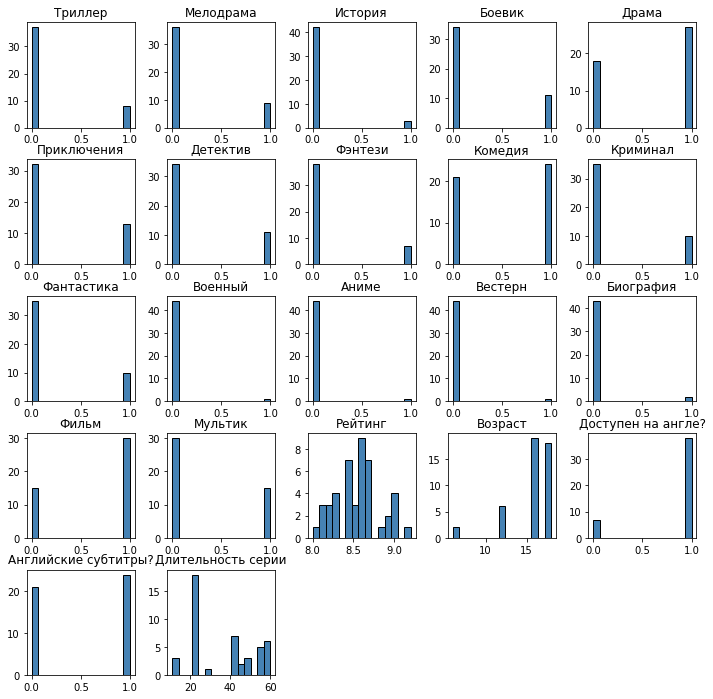

In [4]:
movies.hist(bins = 15, color = 'steelblue', edgecolor = 'black', linewidth=1.0,
           xlabelsize = 10, ylabelsize = 10, grid = False)    
plt.gcf().set_size_inches(12,12)

######  1.4.2 Interpretation of the results obtained by the analysis of histograms

Let's go through each variable (if an expressions of types "i - as j" or "i - like j" are used, this means that the description of j is similar to the description of i):

1) Subtitles are a little more often present than absent, and it is clear that about half of the series are no longer suitable for us if we are interested in subtitles

2) Anime is extremely rare genre (presumably, it appears just 1 time)

3) Biography – as anime (presumably, 2 times)

4) Action movie – is rare, but not very (about 10 times)

5) Western – like anime

6) Military – like a western

7) Age restrictions – mostly 16+ and 18+

8) Detective – as an action movie

9) The duration of the episodes is around 20 minutes in many cases (especially, this is common for cartoons). Also we can see a large number of episodes in the range from 40 to 60 minutes (mostly around an hour)

10) English – almost always yes

11) Drama – more often yes than no

12) History – either as a biography, or slightly more often than a biography

13) Comedy – a little more often yes than no

14) Crime – as an action movie

15) Melodrama – a little less often than crime

16) Cartoon – occurs about 2 times less often than movies

17) Adventures – a little more often than an action movie

18) Rating – has an approximately normal distribution centered around 8.65

19) Thriller – a little less than melodrama

20) Fiction – a little more often than melodrama

21) A movie is about 2 times more often than a cartoon

22) Fantasy – a little less than thriller

# 2 Clustering using K-Means in Python

### 2.1 Data preparation

Firslty, we need to make our data suitable for the model. Since clusters are constructed with the use of numeric features, we will split our data to train set (to do so, we drop just one columns with names) and we will keep the names of movies as labels

In [5]:
df1 = movies.iloc[:, 1:]
df2 = pd.DataFrame(movies.iloc[:, 0])
features, true_labels = df1, df2

In [6]:
features.head()

,Триллер,Мелодрама,История,Боевик,Драма,Приключения,Детектив,Фэнтези,Комедия,Криминал,...,Аниме,Вестерн,Биография,Фильм,Мультик,Рейтинг,Возраст,Доступен на англе?,Английские субтитры?,Длительность серии
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,9.0,18,1,1,23
1,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,8.6,6,1,1,22
2,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,1,9.0,12,1,1,22
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,9.2,16,1,1,22
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,8.7,18,1,1,55


In [7]:
true_labels.head()

,Название
0,Рик и Морти
1,Аватар Аанг
2,Гравити Фолз
3,Друзья
4,Бесстыжие


In [8]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

### 2.2 Standartization

Data preprocessing is very important since in K-Means clustering we deal with Euclidian distance. Therefore, variables with relatively high range (in our case, the duration of episode) will affect our model much more than others. Since we do not want our values be clustered by just some parameters, we will standartise our data

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### 2.3 Very important thing about K-Means

Despite that I find this algorithm the best in terms of clustering (a bit later I will explain why), there are at least two problems with it (probably, that is why some people prefer using other algorithms, such as DBSCAN, for example):

1) Sometimes it can be complicated to choose optimal value of k (number of clusters)

2) The performance of model is very dependent on the initial choice of locations of clusters

As for 2), the common solution is to use K-Means++ instead of random location of points (the method is not explained in details by creators, however, I believe it makes sense to use an advanced algorithm instead of doing random initialization of points). To deal with 1), there are 2 common methods that allow us choose optimal k - Elbow Method and Silhouette Coefficient

### 2.4 Elbow Method

We measure SSE (sum squared error). It decreases within the increase of number of clusters. If the number of clusters will be equal to number of objects, SSE will be equal to 0. When SSE starts to decrease insignificantly with the increase of k, it means that it is time to stop and not to add additional clusters

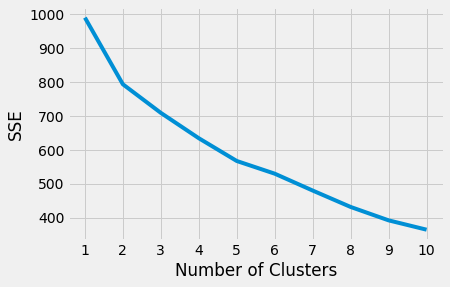

In [10]:
kmeans = KMeans(init = "k-means++", n_clusters = 4, n_init = 10, max_iter = 300, random_state = 42)
kmeans.fit(scaled_features)
# Find the lowest SSE value
kmeans.inertia_
# Indicate final locations of the centroid
kmeans.cluster_centers_
# Indicate a number of iterations required to converge
kmeans.n_iter_
kmeans_kwargs = {"init": "k-means++", "n_init": 10, "max_iter": 300, "random_state": 42,}
# Let's create a list that will hold the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [11]:
kl = KneeLocator(range(1, 11), sse, curve = "convex", direction = "decreasing")
kl.elbow #find the optimal number of clusters

4

### 2.5 Silhouette Score

The basic idea is that a point in a certain cluster should be on average very close to other values in a cluster (in the best case, this average distance is equal to 0) and relatively far away from even the nearest cluster (in the best case, this average distance goes to infinity). The more it is true, the better our model is. The satisfaction of this conditions can be measured by Silhouette Coefficients. The obtained metric is in the range from -1 to 1, and the closer it is to 1, the better it is 

In [12]:
silhouette_coefficients = []
# Notice that we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

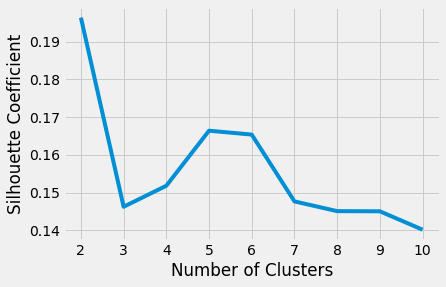

In [13]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### 2.6 The thing I like about K-Means and why I find it as the best clustering algorithm (in these types of problems)

Probably two most important applications of K-Means are:

1) Classification problems (we know the true clusters of train set) and, based on that, we are trying to predict the class of newly obtained values

2) Grouping problems (when do not know anything about the distribution of our values in terms of clusters and we just want to find categories of similar objects)

We are dealing with second issue. My point is that despite that Silhouette Score method tells us the most efficient options is to choose 2 clusters, I can still look at other cases and choose the most suitable for me. In our problem, I do not want to group around 50 movies to 2 clusters, since it provides me with additional challenges of decision-making (suppose a person's favourite series is Game of Thrones and there are 24 objects in the cluster, how will one choose just one out of them to watch?). So, best second option is to choose 4 clusters and this sounds fine for me.

### 2.7 Pipeline for clustering values

Now we will construct a general algorithm to do clustering problems. Here the most important thing is using PCA as a dimensionality reduction, so that our graph can be plotted in 2D, despite that number of features significantly exceeds 2. I will not focus on how PCA workes, as it requires the explanation of SVD and eigenvalues. However, I will leave a source with explanation in the references

In [14]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [15]:
datafile = "file"
labels_file = "file"
data = np.genfromtxt(datafile, delimiter = ",", usecols = range(1,23), skip_header = 1)
true_label_names = np.genfromtxt(labels_file, delimiter = ",", usecols = (1,), skip_header = 1, dtype = "str")

In [16]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)

In [17]:
label_encoder.classes_
n_clusters = len(label_encoder.classes_)

In [18]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
 )

In [19]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters = 4, #I set number of clusters to be 4, otherwise the model will construct 2
                init = "k-means++",
                n_init = 50,
                max_iter = 500,
                random_state = 42,
            ),
        ),
    ]
  )

In [20]:
pipe = Pipeline(
     [
         ("preprocessor", preprocessor),
         ("clusterer", clusterer)
     ]
 )

In [21]:
pipe.fit(data)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=4, n_init=50, n_jobs=None,
                                         precomp

In [22]:
preprocessed_data = pipe["preprocessor"].transform(data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.46711043421338616

In [23]:
adjusted_rand_score(true_labels, predicted_labels)

0.047655791845427314

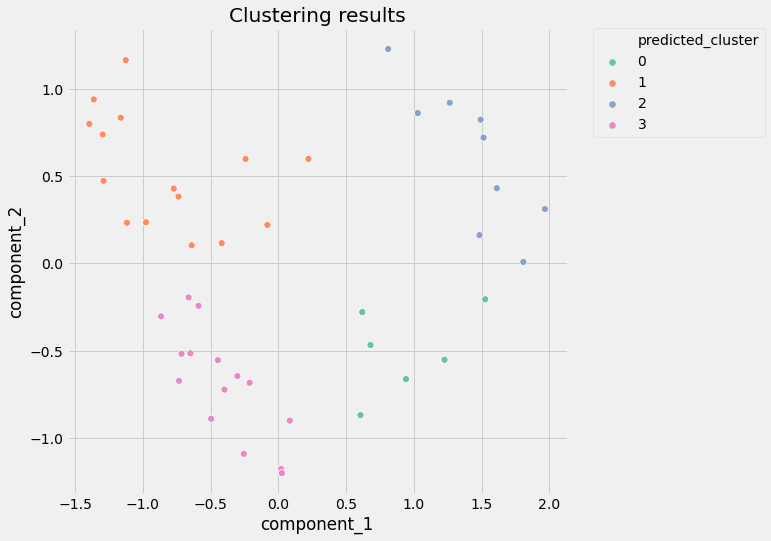

In [24]:
pcadf = pd.DataFrame(pipe["preprocessor"].transform(data), columns = ["component_1", "component_2"],)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot("component_1", "component_2", s = 50, data = pcadf, hue = "predicted_cluster", 
                       palette = "Set2",)

scat.set_title("Clustering results")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.0)
plt.show()

### 2.8 Final table 

Now we can see, in whcih clusters are different movies. Components 1 and 2 are combinations of initial features, transormated to the 2D with the help of PCA

At this moment I will not interpret the reasonability of the results we got. I will just tell that they seem just fine for me, according to my prior belief about the movies

In [25]:
final = pd.concat([df2, pcadf], axis = 'columns')
final = final.sort_values('predicted_cluster')
final

,Название,component_1,component_2,predicted_cluster
0,Рик и Морти,1.526719,-0.205387,0
40,Симпсоны,0.942000,-0.662199,0
36,Дарья,0.606237,-0.868617,0
18,Южный парк,0.680203,-0.466819,0
17,Футурама,1.226476,-0.551466,0
22,Крутой учитель Онидзука,0.619331,-0.278292,0
14,Место встречи изменить нельзя,-1.126602,1.164195,1
26,Братья по оружию,-0.772054,0.429002,1
27,Настоящий детектив,-1.394779,0.799637,1
32,Повар императора,-0.736654,0.382953,1


# 3 Clustering with Orange

### 3.1 Plan

In the initial version of the project, the goal was to describe and compare the results of using different algorithms and summarize the strengths and weaknesses, as well as the specific characteristics of certain clustering techniques within the framework of this task. It was done in a specific tool - Orange (it can be as found in Anaconda, as downloaded by ones own). Now we will briefly summarise 4 algorithms that were used and describe their performance

### 3.2 Algorithms

1) K-Means seeks to minimize the total quadratic deviation of cluster points from the centers of these clusters, that is, it chooses the optimal distribution due to optimization methods. As it was before, the closest to one value of Silhouette score is achieved when two clusters are formed. However, we still choose second best option and choose 4 clusters

2) Hierarchical (the analyzed set of objects is characterized by a certain degree of connectivity, due to which they can be separated into communities). By default and by applying most variants of the height ratio method, we got a big number of clusters, which is the opposite of K-Means situation (remember that there just 2 clusters were optimal). So, for this reason (and also because it is not entirely clear how to set parameters within all specificity of our data), we choose 4 clusters, so it will be easy to compare them with K-Means

3) DBSCAN ('given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away)' - Wikipedia). As a result of applying this algorithm with the standard (proposed by the system) settings, there was found only 1 cluster and several outliers were allocated that did not get into it (roughly speaking, algorithm threw out several objects from the source data). One should immediately think about the fact that this algorithm is not suitable for working with our data type and it is worth focusing on the other 3. This is despite the fact that DBSCAN is usually interpreted as a well-performing algorithm (many ML-experts claim it is better than K-Means). However, here the results are very disappointing and unsatisfactory. I have 2 thoughts about it. First is that DBCAN is best performing when the data is simple to group (remember that our data is rather complicated for this problem). However, in that case each algorithm is expected to perform well. Moreover, there are some questions about the amount of these types of tasks in real life. The second thought is that DBSCAN performs well in the case of labeled training dataset, where we classify our objects. In this project, the hypothesis will not be tested

4) Louvain (here nodes are moved one after another in one of the neighboring communities in order to maximize modularity; in this case, nodes can be moved several times until the Pareto optimum is reached). Remember that we used the Louvain technique in identification of the communities of faculties in HSE (one of my last projects). I have got some questions, concerning why sometimes I use clustering, and in other cases - community detection. The answer will be provided in the end of the this (third) section. As a result, there were 4 clusters

### 3.3 Realisation of algorithms in Orange

As usually, data was preprocessed (however, here I used normalisation from 0 to 1 instead of standartisation, as it was before). After that we applied all 4 algorithms in the Orange framework. Here is how it looks like:

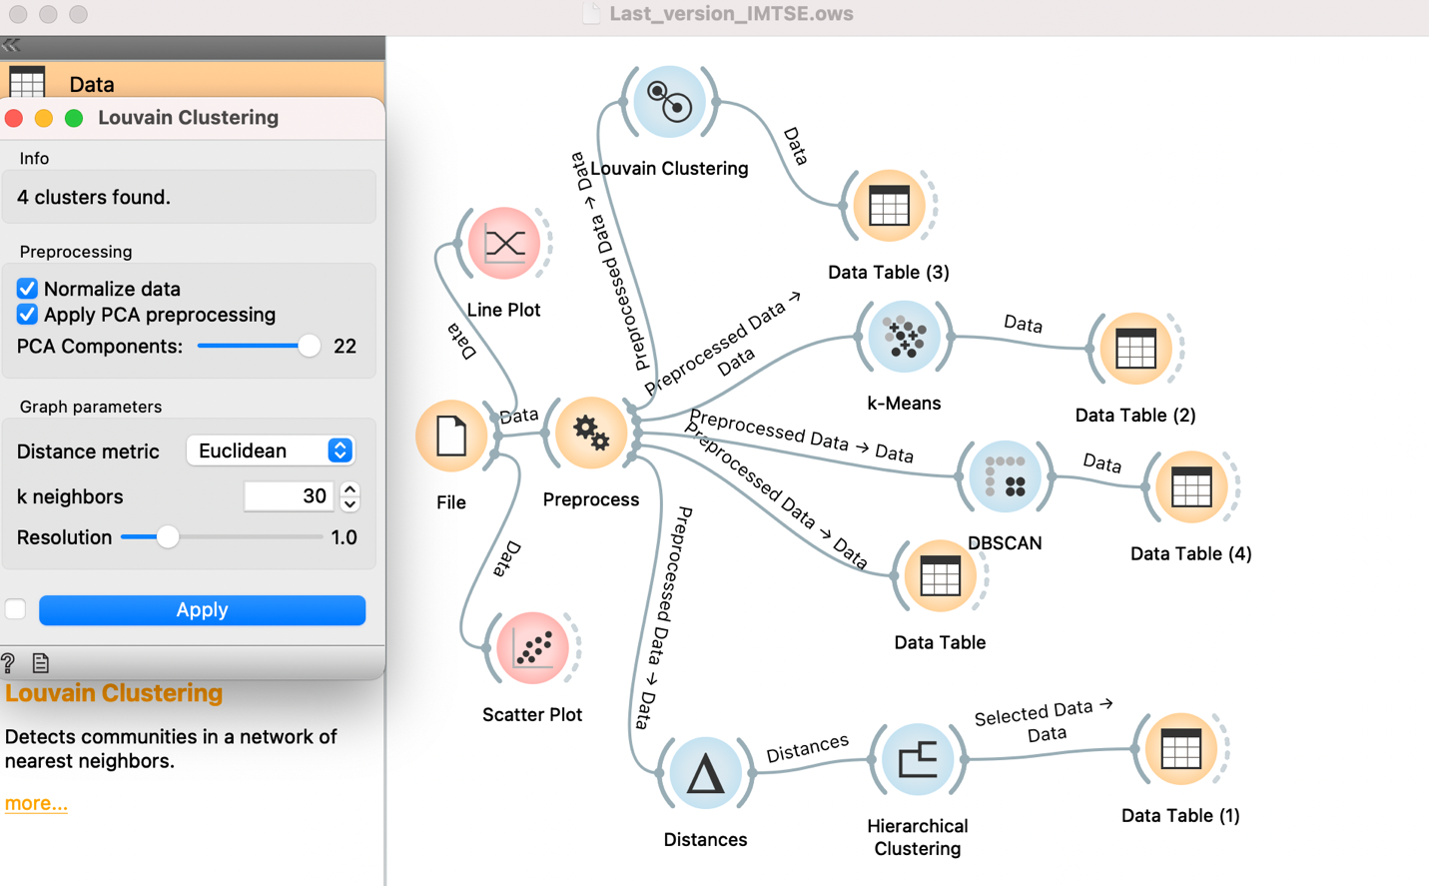

In [26]:
from IPython.display import Image
Image('file')

### 3.4 Observations

1) The Louvain method gave us 4 clusters, where the last cluster contained only 1 element – a "Firefly". It was  decided to remove this cluster, and to remove the "Firefly" in the first cluster to the "Black Mirror", since they are both films and fiction, and, as we have seen before, fiction is mostly relevant for cartoons.

2) The Hierarchical method gave us 4 clusters, however, while the second and fourth clusters contain many elements, the first and third clusters contain 2 elements each. At the same time, at first glance it seems that the first cluster rather refers to the second, and the third to the fourth. Therefore, it was decided to try out an algorithm for finding two clusters. Indeed, if we compare it with the previous one, then the first cluster connected to the second, and the third to the fourth. That is why the original cluster comparison has been redone in favor of leaving only two clusters in the Hierarchical method

### 3.5 Results in a table


In [27]:
df = pd.read_excel('file')
df.head()

,k-means(1),k-means(2),k-means(3),k-means(4),Hierarchical(1),Hierarchical(2),Louvain(1),Louvain(2),Louvain(3)
0,Доктор Хаус,Рик и Морти,Друзья,Сопрано,Друзья,Рик и Морти,Бесстыжие,Рик и Морти,Друзья
1,Игра престолов,Аватар Аанг,Бесстыжие,Во все тяжкие,Бесстыжие,Гравити Фолз,Сопрано,Аватар Аанг,12 стульев
2,Светлячок,Гравити Фолз,Клиника,Место встречи изменить нельзя,Сопрано,Человек-паук,Клиника,Гравити Фолз,Силиконовая долина
3,Чернобыль,По ту сторону изгороди,Теория большого взрыва,Настоящий детектив,Клиника,Крутой учитель Онидзука,Во все тяжкие,Теория большого взрывва,Секс в большом городе
4,Йеллоустоун,Футурама,Офис,Ликивидация,Теория большого взрывва,Крайний космос,Доктор Хаус,Офис,NaN


### 3.6 Analysis of results

All in all, K-Means algorithm assigned cartoons to a separate category, then divided the films into 2 categories based on their similarity to cartoons, and sent those mvoies that did not fit into the first 3 categories to the last category; the Hierarchical algorithm divided the movies into cartoons and films, and the Louvain algorithm allocated most of the films into one category. In the second category there are cartoons and movies, which, in its opinion, are similar to cartoons, and the third category is objects that are most unlike others.

An important observation: all three algorithms assigned all or almost all cartoons to the same category, without separating them from each other in any way. Therefore, we can conclude that it makes sense to cluster cartoons separately (without movies) in order to find out how certain cartoons may differ from each other. 

Each of the three algorithms has its pros and cons:

1) K-means – despite the fact that it reasonably and logically divides objects into 3 categories, the last category does not have any pronounced meaning (at least, I did not find it), expect for the collection of TV series that did not fit into 3 other categories

2) Hierarchical is the most ambiguous of the presented algorithms, since we can easily understand whether the series is a cartoon or a movie by our own

3) Louvain – distributes movies and TV series in a rather primitive way, but each cluster has its own logical description

### 3.7 Clustering vs Community detection

In clustering problems, we group our objects according to their characteristics. Hence, we come up with with several groups that, on awerage, share similar or identical charasterics. The commmon example is the flower recognition (remember the iris dataset). In community detection problems, we are not interested in the characteristics at all. We are interested just in the interaction of objects with each other. The typical scenario are the social networks, where people communicate with each other. When the system recommends you to take a look at the possible friend, it is not because the person shares similar charasterics, it is because you are probably communicating with same people

# 4 Conclusion

In the scope of our task, the most effective algorithm turned out to be K-Means. The results of the Louvain algorithm also suit me. As for Hierarchical clustering, the results of this algorithm turned out to be quite primitive (and this after adjustments we made). Moreover, in modern problems, this algorithm is rarely used because of its computational complexity. DBSCAN worked the worst, because it did not solve the clustering problem, but only got rid of outliers. These results can be used, and they clearly give us more information than Hierarchical clustering. However, the original task was not solved

# 5 Plans for the future

By applying clustering techniques, we understood that it is resonable to look at films and cartoons separately from each other. Also, I want to make a bigger dataset for deeper analysis. So, for now there are two main things to do:

1) Take top-250 Kinopoisk series

2) Do Clustering separately for films and cartoons

#  6 References

1) https://realpython.com/k-means-clustering-python/#what-is-clustering (how to identify a perfect k and do K-Means in Python)

2) StatQuest (intuitive explanation of how basic clustering algorithms work)

3) Mathematics for Machine Learning (in chapter 10 of this book one can find good explanation of how PCA works)